In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e76ec952-6b8e-2abf-8111-101ed474d5ea)


# Importing Dependencies

In [5]:
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import os

Downloading Dataset

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

 99% 2.03G/2.06G [00:18<00:00, 58.3MB/s]
100% 2.06G/2.06G [00:18<00:00, 119MB/s] 


In [ ]:
! unzip chest-xray-covid19-pneumonia.zip

Data

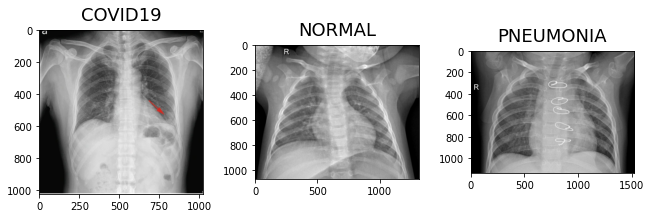

In [9]:
dataset='/content/Data'
train_folder = os.path.join(dataset,"train")


images = []


for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

# Image Pre-Processing

In [13]:
train_datagen = ImageDataGenerator(
        rotation_range=10, 
        zoom_range=0.2, 
        horizontal_flip=True, 
        brightness_range=[0.2,1.2],
        validation_split= 0.2,
        rescale= 1./255) 

test_datagen = ImageDataGenerator(rescale=1./255,)

train_path='/content/Data/train'
test_path = '/content/Data/test'

train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(200 , 200),
        batch_size=32,
        class_mode = "categorical",
        classes= ['NORMAL','COVID19','PNEUMONIA'],
        shuffle= True)

test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(200 , 200),
        batch_size=32, 
        class_mode = "categorical",
        classes= ['NORMAL','COVID19','PNEUMONIA'],
        shuffle= True )

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# After Data Augmentation

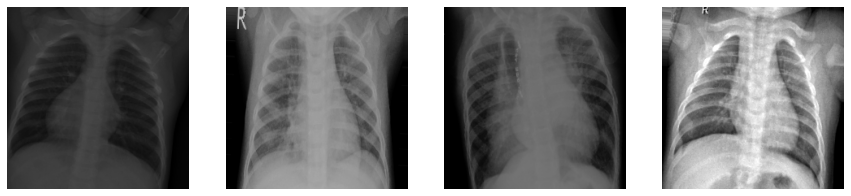

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_set)[0]

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

Classes

In [14]:
class_map = train_set.class_indices
class_map

{'NORMAL': 0, 'COVID19': 1, 'PNEUMONIA': 2}

# Model Building

In [15]:
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

## Simple CNN

In [16]:
image_size = (200,200,3)

model = Sequential()
model.add(Conv2D(128,(5,5),activation = "relu", input_shape = image_size))
model.add(MaxPool2D())
model.add(Dropout(0.3))

model.add(Conv2D( 160, (3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(3, activation = "softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 160)       184480    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 160)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 160)       0

In [17]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
history= model.fit(train_set,epochs=20,validation_data=test_set)

Epoch 1/20
161/161 [==============================] - 202s 1s/step - loss: 1.5699 - accuracy: 0.6975 - val_loss: 0.6282 - val_accuracy: 0.8292
Epoch 2/20
161/161 [==============================] - 185s 1s/step - loss: 0.5121 - accuracy: 0.7897 - val_loss: 0.5180 - val_accuracy: 0.7539
Epoch 3/20
161/161 [==============================] - 186s 1s/step - loss: 0.4445 - accuracy: 0.8229 - val_loss: 0.2953 - val_accuracy: 0.8882
Epoch 4/20
161/161 [==============================] - 186s 1s/step - loss: 0.3848 - accuracy: 0.8472 - val_loss: 0.3883 - val_accuracy: 0.8408
Epoch 5/20
161/161 [==============================] - 185s 1s/step - loss: 0.3772 - accuracy: 0.8503 - val_loss: 0.2649 - val_accuracy: 0.9123
Epoch 6/20
161/161 [==============================] - 185s 1s/step - loss: 0.3779 - accuracy: 0.8490 - val_loss: 0.3446 - val_accuracy: 0.8758
Epoch 7/20
161/161 [==============================] - 185s 1s/step - loss: 0.3525 - accuracy: 0.8579 - val_loss: 0.2882 - val_accuracy: 0.9247

## **Plot**

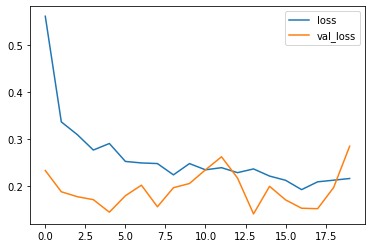

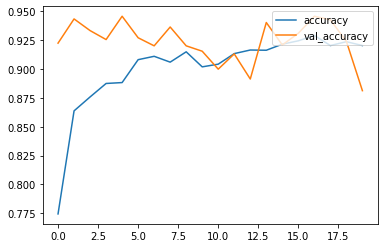

In [34]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [20]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9055209755897522
validation_accuracy 0.9153726696968079


## **Confusion Matrix**

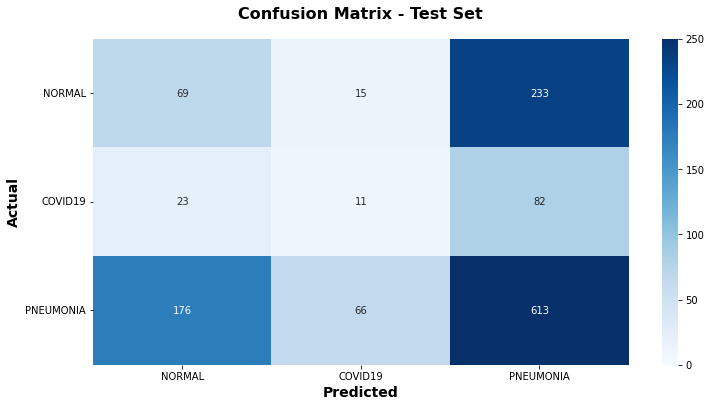

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ['NORMAL','COVID19','PNEUMONIA']

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## **Scores**

In [23]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.26      0.22      0.24       317
           1       0.12      0.09      0.11       116
           2       0.66      0.72      0.69       855

    accuracy                           0.54      1288
   macro avg       0.35      0.34      0.34      1288
weighted avg       0.51      0.54      0.52      1288



## **Prediction**

In [24]:
class_dict = {0:'NORMAL',
              1:'COVID19',
              2:'PNEUMONIA'}

prediction:  NORMAL


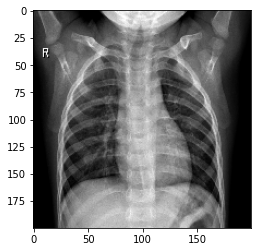

In [28]:
file_path =  '/test/NORMAL/NORMAL(1272).jpg'
test_image = cv2.imread(dataset + file_path)
test_image = cv2.resize(test_image, (200,200),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

# VGG16

In [29]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

In [ ]:
vgg = VGG16(input_shape= [200,200,3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

In [ ]:
vgg.summary()

In [32]:
x = Flatten()(vgg.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [41]:
history= model.fit(train_set,epochs=2,validation_data=test_set)

Epoch 1/2
161/161 [==============================] - 186s 1s/step - loss: 0.1987 - accuracy: 0.9255 - val_loss: 0.1380 - val_accuracy: 0.9433
Epoch 2/2
161/161 [==============================] - 182s 1s/step - loss: 0.1987 - accuracy: 0.9288 - val_loss: 0.2102 - val_accuracy: 0.9239


## **Plot**

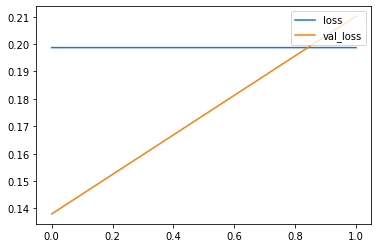

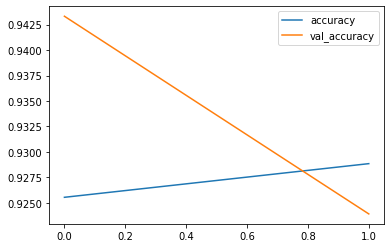

In [42]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [43]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9288491606712341
validation_accuracy 0.9239130616188049


## **Confusion Matrix**

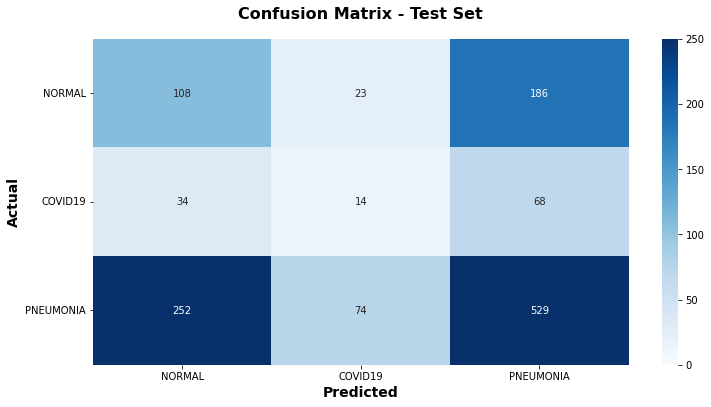

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ['NORMAL','COVID19','PNEUMONIA']

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## **Scores**

In [45]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.27      0.34      0.30       317
           1       0.13      0.12      0.12       116
           2       0.68      0.62      0.65       855

    accuracy                           0.51      1288
   macro avg       0.36      0.36      0.36      1288
weighted avg       0.53      0.51      0.51      1288



# ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(200,200,3))

In [47]:
for i in resnet.layers:
  i.trainable = False

In [ ]:
resnet.summary()

In [56]:
x = Flatten()(resnet.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [58]:
history= model.fit(train_set,epochs=5,validation_data=test_set)

Epoch 1/5
161/161 [==============================] - 193s 1s/step - loss: 0.8354 - accuracy: 0.6645 - val_loss: 0.8339 - val_accuracy: 0.6638
Epoch 2/5
161/161 [==============================] - 184s 1s/step - loss: 0.8343 - accuracy: 0.6645 - val_loss: 0.8339 - val_accuracy: 0.6638
Epoch 3/5
161/161 [==============================] - 186s 1s/step - loss: 0.8368 - accuracy: 0.6645 - val_loss: 0.8339 - val_accuracy: 0.6638
Epoch 4/5
161/161 [==============================] - 185s 1s/step - loss: 0.8345 - accuracy: 0.6645 - val_loss: 0.8339 - val_accuracy: 0.6638
Epoch 5/5
161/161 [==============================] - 182s 1s/step - loss: 0.8351 - accuracy: 0.6645 - val_loss: 0.8339 - val_accuracy: 0.6638


## **Plot**

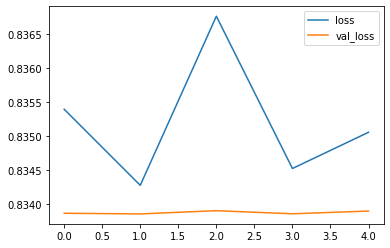

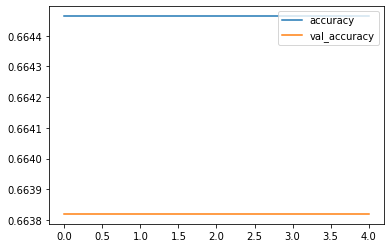

In [59]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

## **Confusion Matrix**

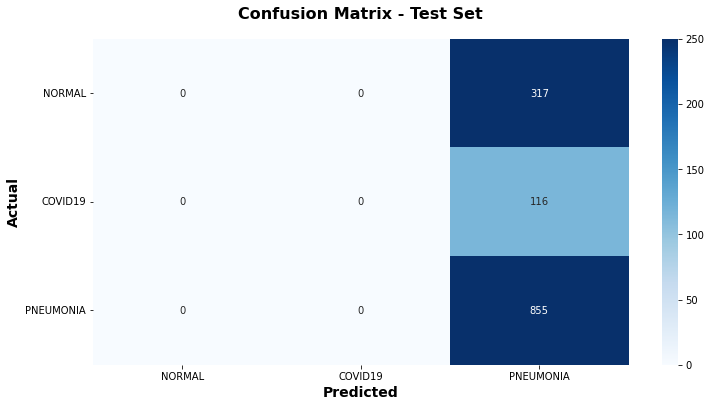

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ['NORMAL','COVID19','PNEUMONIA']

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## **Score**

In [60]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.664463460445404
validation_accuracy 0.6638198494911194


# DenseNet121

In [ ]:
densenet = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",input_shape=(200,200,3))

In [64]:
for i in densenet.layers:
  i.trainable = False

In [ ]:
densenet.summary()

In [66]:
x = Flatten()(densenet.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=densenet.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [70]:
history= model.fit(train_set,epochs=2,validation_data=test_set)

Epoch 1/2
161/161 [==============================] - 196s 1s/step - loss: 0.2408 - accuracy: 0.9104 - val_loss: 0.1978 - val_accuracy: 0.9480
Epoch 2/2
161/161 [==============================] - 179s 1s/step - loss: 0.2157 - accuracy: 0.9215 - val_loss: 0.1358 - val_accuracy: 0.9526


## **Plot**

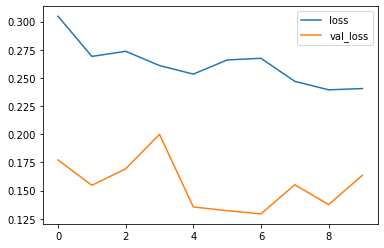

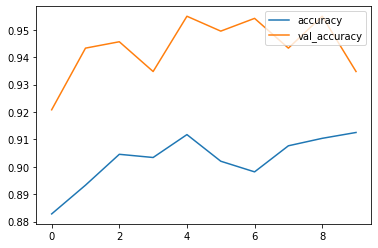

In [69]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

## **Confusion Matrix**

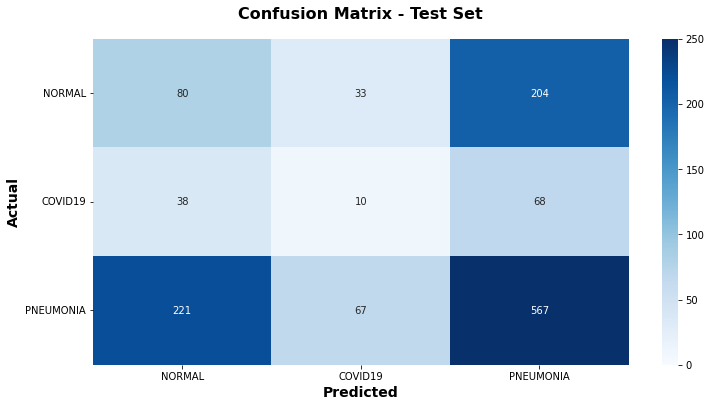

In [71]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ['NORMAL','COVID19','PNEUMONIA']

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [73]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9214618802070618
validation_accuracy 0.9526397585868835


## **Scores**

In [72]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.24      0.25      0.24       317
           1       0.09      0.09      0.09       116
           2       0.68      0.66      0.67       855

    accuracy                           0.51      1288
   macro avg       0.33      0.33      0.33      1288
weighted avg       0.51      0.51      0.51      1288

